# A simple profiler

This is the first cut at a simple time-spent profiler for nodes. 

The code to profile is just the previously defined FRED code.

Although primitive, the profiler output does show a few things:
1. The bulk of the time is spent in fetching data pages.
2. The ExternalRefData.state method is a mess:
 * It should load data pages lazily, not deeply in the EncDec mechanics
 * The low-level ObjMeta/dataField code hides some stuff we would like to expose at the node level
3. Wow, this code is quite slow. Especially when my laptop is overheating:
 * Refactored FredSeries so that it doesn't load/persist release data by default
 * We'll fix the rest of the slowness later

In [1]:
import mand.core

from mand.core import Entity, node, Context, _tr, ObjectDb, _DBO, EncDec
from mand.core import displayDict, displayListOfDicts, displayMarkdown
from mand.core import Monitor, PrintMonitor, SummaryMonitor
from mand.lib.extrefdata import ExternalRefData, dataField

from mand.user.refdata.FRED import FredManager, FredSeries, FredCategory

db = ObjectDb(name='production-1', inMem=False, ro=True)

%matplotlib inline


In [2]:
import time

class ProfileMonitor(Monitor):

    def __init__(self, mode=None):
        self.stack = []
        self.result = []
        self.mode = mode
        
    def message(self, sys, depthInc, action, **kw):
        if depthInc == 1:
            v = [kw, time.clock(), 0]
            self.stack.append(v)
            
        if depthInc == -1:
            kw, start, tSub = self.stack.pop()
            t = time.clock() - start
            tFn = t - tSub
            if self.stack:
                self.stack[-1][-1] += t
            
            self.result.append((tFn, t, sys, kw))
             
    def dumpRaw(self):
        for tFn, t, sys, kw in self.result:
            key = self.kwToStr(kw)
            print '%8.4f %8.4f %-16s: %s' % (tFn, t, sys, key)
            
    def displaySum(self):
        if not self.result:
            displayMarkdown('No profile info was recorded.')
        n = {}
        cumT = {}
        cumTCalc = {}
        tScale = 1e6
        for tFn, t, sys, kw in self.result:
            if 'path'in kw:
                fn = kw.get('path', '//').split('/')[2]
            else:
                fn = kw.get('key').fullName()
            key = (sys, fn)
            cumT[key] = cumT.get(key, 0) + t * tScale
            cumTCalc[key] = cumTCalc.get(key, 0) + tFn * tScale
            n[key] = n.get(key, 0) + 1
        res = []
        def f(d):
            return format(int(d), ',d')
        for key in n:
            line = { 'n':         f(n[key]), 
                     'cumT':      f(cumT[key]),
                     'cumT/call': f(cumT[key]/n[key]),
                     'calcT':     f(cumTCalc[key]),
                     'sys':       key[0],
                     'fn':        key[1],
                     'key':       cumT[key],
                     }
            res.append(line)
        res = sorted(res, key=lambda d: -d['key'])
        txt = """### Profile by nodes. 
* times are in microseconds
* cumT is total time spent in funtion
* calcT is time spent in function, but not in a child node"""
        displayMarkdown(txt)
        displayListOfDicts(res, names=['fn', 'n', 'cumT', 'calcT', 'cumT/call', 'sys'])
        
    def onExit(self):
        mode = self.mode
        if mode is None:
            self.dumpRaw()
        elif mode == 'sum':
            self.displaySum()
        else:
            assert False, 'unknown profiler mode: %s' % mode

In [3]:
class Test(_DBO):
    @node
    def info(self):
        fc = FredCategory.get('94', self.meta.db, create=True)
        info = []
        if fc.seriesNames():
            for s in fc.series():
                seriesInfo = s.info()
                info.append(dict([ (k, seriesInfo[k]) for k in ['id', 'title'] ]) )
        return info
        
with ProfileMonitor(mode='sum'):
    with PrintMonitor(include='Web'):
        t = Test('Test', db=db)
        info = t.info()
        
print 'count is:', len(info)
displayListOfDicts(info)

### Profile by nodes. 
* times are in microseconds
* cumT is total time spent in funtion
* calcT is time spent in function, but not in a child node

|fn|n|cumT|calcT|cumT/call|sys|
|-|-|-|-|-|-|
|Test:info|1|18,389,895|18|18,389,895|GetValue
|Test:info|1|18,389,876|1,182|18,389,876|GetValue/Calc
|ExternalRefData:state|28|18,338,535|420|654,947|GetValue
|ExternalRefData:state|27|18,338,115|5,377|679,189|GetValue/Calc
|ExternalDataPage|313|18,194,631|18,194,631|58,129|Db.Get
|RefData:state|27|138,106|291|5,115|GetValue
|RefData:state|27|137,814|55,996|5,104|GetValue/Calc
|RefDataUpdateEvent|27|73,779|73,779|2,732|Db.Get
|FredCategory:series|1|46,756|16|46,756|GetValue
|FredCategory:series|1|46,739|484|46,739|GetValue/Calc
|FredSeries|26|46,250|46,250|1,778|Db.Get
|Clock:cutoffs|54|4,565|207|84|GetValue
|Clock:cutoffs|1|4,358|51|4,358|GetValue/Calc
|Clock:parent|1|4,302|12|4,302|GetValue
|Clock:parent|1|4,290|2,406|4,290|GetValue/Calc
|FredCategory|1|3,406|3,406|3,406|Db.Get
|RefData:clock|54|3,154|504|58|GetValue
|RefData:clock|27|2,649|487|98|GetValue/Calc
|Clock|1|2,161|2,161|2,161|Db.Get
|Entity:clock|2|1,757|22|878|GetValue
|Entity:clock|1|1,734|30|1,734|GetValue/Calc
|RootClock|1|1,703|1,703|1,703|Db.Get
|Event:amends|27|179|179|6|GetValue
|RefDataUpdateEvent:data|27|139|139|5|GetValue
|RootClock:cutoffs|3|130|19|43|GetValue
|RootClock:cutoffs|1|110|49|110|GetValue/Calc
|CosmicAll:dbState|1|39|34|39|GetValue
|RootClock:cosmicAll|1|21|13|21|GetValue
|RootClock:cosmicAll|1|8|8|8|GetValue/Calc
|CosmicAll:dbState|1|5|5|5|GetValue/Calc

count is: 26


|id|title|
|-|-|
|DEXBZUS|Brazil / U.S. Foreign Exchange Rate
|DEXCAUS|Canada / U.S. Foreign Exchange Rate
|DEXCHUS|China / U.S. Foreign Exchange Rate
|DEXDNUS|Denmark / U.S. Foreign Exchange Rate
|DEXHKUS|Hong Kong / U.S. Foreign Exchange Rate
|DEXINUS|India / U.S. Foreign Exchange Rate
|DEXJPUS|Japan / U.S. Foreign Exchange Rate
|DEXKOUS|South Korea / U.S. Foreign Exchange Rate
|DEXMAUS|Malaysia / U.S. Foreign Exchange Rate
|DEXMXUS|Mexico / U.S. Foreign Exchange Rate
|DEXNOUS|Norway / U.S. Foreign Exchange Rate
|DEXSDUS|Sweden / U.S. Foreign Exchange Rate
|DEXSFUS|South Africa / U.S. Foreign Exchange Rate
|DEXSIUS|Singapore / U.S. Foreign Exchange Rate
|DEXSLUS|Sri Lanka / U.S. Foreign Exchange Rate
|DEXSZUS|Switzerland / U.S. Foreign Exchange Rate
|DEXTAUS|Taiwan / U.S. Foreign Exchange Rate
|DEXTHUS|Thailand / U.S. Foreign Exchange Rate
|DEXUSAL|U.S. / Australia Foreign Exchange Rate
|DEXUSEU|U.S. / Euro Foreign Exchange Rate
|DEXUSNZ|U.S. / New Zealand Foreign Exchange Rate
|DEXUSUK|U.S. / U.K. Foreign Exchange Rate
|DEXVZUS|Venezuela / U.S. Foreign Exchange Rate
|DTWEXB|Trade Weighted U.S. Dollar Index: Broad
|DTWEXM|Trade Weighted U.S. Dollar Index: Major Currencies
|DTWEXO|Trade Weighted U.S. Dollar Index: Other Important Trading...

Swiss Francs to One U.S. Dollar


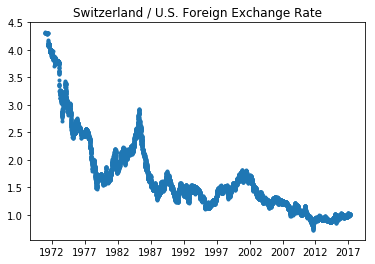

U.S. Dollars to One British Pound


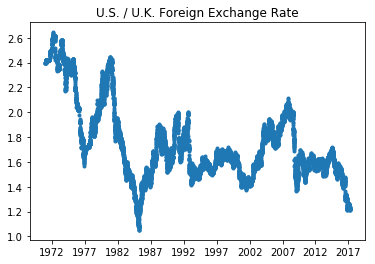

In [4]:
chf = FredSeries.get('DEXSZUS', db, create=True)
print chf.info()['units']
chf.plot()

gbp = FredSeries.get('DEXUSUK', db, create=True)
print gbp.info()['units']
gbp.plot()

# Check things have a reasonable default display() method [Test]

# DEXUSEU

|key|value|
|-|-|
|frequency|Daily
|frequency_short|D
|id|DEXUSEU
|last_updated|2017-03-20 15:51:31-05
|notes|Noon buying rates in New York City for cable transfers pa...
|observation_end|2017-03-17
|observation_start|1999-01-04
|popularity|77
|realtime_end|2017-03-27
|realtime_start|2017-03-27
|seasonal_adjustment|Not Seasonally Adjusted
|seasonal_adjustment_short|NSA
|title|U.S. / Euro Foreign Exchange Rate
|units|U.S. Dollars to One Euro
|units_short|U.S. $ to  1 Euro

                 Web urlopen url: https://api.stlouisfed.org/fred/series/observations?series_id=DEXUSEU&realtim...


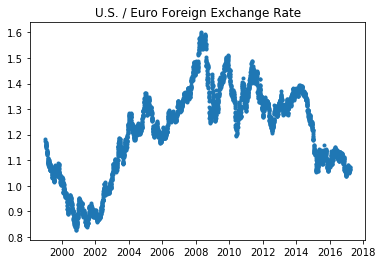

### Profile by nodes. 
* times are in microseconds
* cumT is total time spent in funtion
* calcT is time spent in function, but not in a child node

|fn|n|cumT|calcT|cumT/call|sys|
|-|-|-|-|-|-|
|FredSeries:data|1|334,438|16|334,438|GetValue
|FredSeries:data|1|334,422|103|334,422|GetValue/Calc
|FredReleases:data|1|330,921|36|330,921|GetValue
|FredReleases:data|1|330,884|118,047|330,884|GetValue/Calc
|FredReleases:allObservations|1|212,774|25|212,774|GetValue
|FredReleases:allObservations|1|212,749|9,517|212,749|GetValue/Calc
|ExternalRefData:state|3|203,206|48|67,735|GetValue
|ExternalRefData:state|1|203,158|200,599|203,158|GetValue/Calc
|FredSeries:releases|1|3,397|18|3,397|GetValue
|FredSeries:releases|1|3,378|83|3,378|GetValue/Calc
|FredReleases|1|3,287|3,287|3,287|Db.Get
|RefData:state|1|2,508|14|2,508|GetValue
|RefData:state|1|2,494|2,431|2,494|GetValue/Calc
|FredReleases:fredClock|1|53|21|53|GetValue
|RefData:clock|2|51|26|25|GetValue
|ExternalDataPage:data|5|47|47|9|GetValue
|FredSeries:name|2|43|35|21|GetValue
|FredReleases:fredClock|1|32|32|32|GetValue/Calc
|FredReleases:fredManager|1|25|9|25|GetValue
|RefData:clock|1|25|25|25|GetValue/Calc
|FredReleases:name|1|18|9|18|GetValue
|FredReleases:fredManager|1|15|15|15|GetValue/Calc
|Clock:cutoffs|2|11|11|5|GetValue
|FredReleases:name|1|8|8|8|GetValue/Calc
|FredClock:cutoffs|1|8|8|8|GetValue
|FredSeries:name|1|8|8|8|GetValue/Calc
|FredManager:rootUrl|1|2|2|2|GetValue
|FredManager:apiKey|1|2|2|2|GetValue

In [5]:
with ProfileMonitor(mode='sum'):
    with PrintMonitor(include='Web'):
        eur = FredSeries.get('DEXUSEU', db, create=True)
        eur.display()

# Using a read-only db [Test]

Even with a read-only db, we should still be able to do something useful. We just don't try to
persist newly created objects:

In [6]:
fc = FredCategory.get('33001', db=db, create=True)
fc.display()

# Income Distribution

* 0 sub-categories
* 65 series

|id|title|popularity|frequency|units|
|-|-|-|-|-|
|MEHOINUSA672N|Real Median Household Income in the United States|91|Annual|2015 CPI-U-RS Adjusted Dollars
|MEPAINUSA672N|Real Median Personal Income in the United States|71|Annual|2015 CPI-U-RS Adjusted Dollars
|MEFAINUSA672N|Real Median Family Income in the United States|65|Annual|2015 CPI-U-RS Adjusted Dollars
|MEHOINUSA646N|Median Household Income in the United States|61|Annual|Current Dollars
|GINIALLRH|Income Gini Ratio for Households by Race of Householder, ...|54|Annual|Ratio
|GINIALLRF|Income Gini Ratio of Families by Race of Householder, All...|50|Annual|Ratio
|MEFAINUSA646N|Median Family Income in the United States|43|Annual|Current Dollars
|MAFAINUSA646N|Mean Family Income in the United States|42|Annual|Current Dollars
|MAPAINUSA672N|Real Mean Personal Income in the United States|41|Annual|2015 CPI-U-RS Adjusted Dollars
|GINIBAOICH|Income Gini Ratio for Households by Race of Householder, ...|38|Annual|Ratio
|MAFAINUSA672N|Real Mean Family Income in the United States|37|Annual|2015 CPI-U-RS Adjusted Dollars
|MEPAINUSA646N|Median Personal Income in the United States|34|Annual|Current Dollars
|MAPAINUSA646N|Mean Personal Income in the United States|33|Annual|Current Dollars
|GINIWAF|Income Gini Ratio of Families by Race of Householder, Whi...|31|Annual|Ratio
|MEFAINUSNEA672N|Real Median Family Income in Northeast Census Region|28|Annual|2015 CPI-U-RS Adjusted Dollars
|GINIAAF|Income Gini Ratio of Families by Race of Householder, Asi...|27|Annual|Ratio
|MEFAINUSMWA672N|Real Median Family Income in Midwest Census Region|27|Annual|2015 CPI-U-RS Adjusted Dollars
|MEFAINUSWEA672N|Real Median Family Income in West Census Region|27|Annual|2015 CPI-U-RS Adjusted Dollars
|GINIBAF|Income Gini Ratio of Families by Race of Householder, Bla...|26|Annual|Ratio
|MEFAINUSSOA672N|Real Median Family Income in South Census Region|24|Annual|2015 CPI-U-RS Adjusted Dollars
|MEPAINUSMWA672N|Real Median Personal Income in Midwest Census Region|20|Annual|2015 CPI-U-RS Adjusted Dollars
|MAFAINUSMWA672N|Real Mean Family Income in Midwest Census Region|19|Annual|2015 CPI-U-RS Adjusted Dollars
|MEPAINUSMWA646N|Median Personal Income in Midwest Census Region|16|Annual|Current Dollars
|GINIWANHF|Income Gini Ratio of Families by Race of Householder, Whi...|14|Annual|Ratio
|MEPAINUSSOA672N|Real Median Personal Income in South Census Region|14|Annual|2015 CPI-U-RS Adjusted Dollars
|GINIHARH|Income Gini Ratio for Households by Race of Householder, ...|11|Annual|Ratio
|GINIWAH|Income Gini Ratio for Households by Race of Householder, ...|11|Annual|Ratio
|MEFAINUSMWA646N|Median Family Income in Midwest Census Region|11|Annual|Current Dollars
|MEFAINUSNEA646N|Median Family Income in Northeast Census Region|11|Annual|Current Dollars
|MAPAINUSMWA672N|Real Mean Personal Income in Midwest Census Region|11|Annual|2015 CPI-U-RS Adjusted Dollars
|MEPAINUSNEA672N|Real Median Personal Income in Northeast Census Region|11|Annual|2015 CPI-U-RS Adjusted Dollars
|MEPAINUSWEA672N|Real Median Personal Income in West Census Region|11|Annual|2015 CPI-U-RS Adjusted Dollars
|GINIBAH|Income Gini Ratio for Households by Race of Householder, ...|7|Annual|Ratio
|GINIWH|Income Gini Ratio for Households by Race of Householder, ...|7|Annual|Ratio
|MEPAINUSNEA646N|Median Personal Income in Northeast Census Region|7|Annual|Current Dollars
|MAFAINUSSOA672N|Real Mean Family Income in South Census Region|7|Annual|2015 CPI-U-RS Adjusted Dollars
|MAPAINUSSOA672N|Real Mean Personal Income in South Census Region|7|Annual|2015 CPI-U-RS Adjusted Dollars
|MAPAINUSWEA672N|Real Mean Personal Income in West Census Region|7|Annual|2015 CPI-U-RS Adjusted Dollars
|GINIAAH|Income Gini Ratio for Households by Race of Householder, ...|0|Annual|Ratio
|GINIAAOICH|Income Gini Ratio for Households by Race of Householder, ...|0|Annual|Ratio
|GINIBH|Income Gini Ratio for Households by Race of Householder, ...|0|Annual|Ratio
|GINIWANHH|Income Gini Ratio for Households by Race of Householder, ...|0|Annual|Ratio
|GINIWAOICH|Income Gini Ratio for Households by Race of Householder, ...|0|Annual|Ratio
|GINIWNHH|Income Gini Ratio for Households by Race of Householder, ...|0|Annual|Ratio
|GINIAAOICF|Income Gini Ratio of Families by Race of Householder, Asi...|0|Annual|Ratio
|GINIBF|Income Gini Ratio of Families by Race of Householder, Bla...|0|Annual|Ratio
|GINIBAOICF|Income Gini Ratio of Families by Race of Householder, Bla...|0|Annual|Ratio
|GINIHARF|Income Gini Ratio of Families by Race of Householder, His...|0|Annual|Ratio
|GINIWF|Income Gini Ratio of Families by Race of Householder, Whi...|0|Annual|Ratio
|GINIWNHF|Income Gini Ratio of Families by Race of Householder, Whi...|0|Annual|Ratio
|MAFAINUSMWA646N|Mean Family Income in Midwest Census Region|0|Annual|Current Dollars
|MAFAINUSNEA646N|Mean Family Income in Northeast Census Region|0|Annual|Current Dollars
|MAFAINUSSOA646N|Mean Family Income in South Census Region|0|Annual|Current Dollars
|MAFAINUSWEA646N|Mean Family Income in West Census Region|0|Annual|Current Dollars
|MAPAINUSMWA646N|Mean Personal Income in Midwest Census Region|0|Annual|Current Dollars
|MAPAINUSNEA646N|Mean Personal Income in Northeast Census Region|0|Annual|Current Dollars
|MAPAINUSSOA646N|Mean Personal Income in South Census Region|0|Annual|Current Dollars
|MAPAINUSWEA646N|Mean Personal Income in West Census Region|0|Annual|Current Dollars
|MEFAINUSSOA646N|Median Family Income in South Census Region|0|Annual|Current Dollars
|MEFAINUSWEA646N|Median Family Income in West Census Region|0|Annual|Current Dollars
|MEPAINUSSOA646N|Median Personal Income in South Census Region|0|Annual|Current Dollars
|MEPAINUSWEA646N|Median Personal Income in West Census Region|0|Annual|Current Dollars
|MAFAINUSNEA672N|Real Mean Family Income in Northeast Census Region|0|Annual|2015 CPI-U-RS Adjusted Dollars
|MAFAINUSWEA672N|Real Mean Family Income in West Census Region|0|Annual|2015 CPI-U-RS Adjusted Dollars
|MAPAINUSNEA672N|Real Mean Personal Income in Northeast Census Region|0|Annual|2015 CPI-U-RS Adjusted Dollars

In [7]:
with ProfileMonitor(mode='sum'):
    fc = FredCategory.get('1', db=db, create=True)
    fc.display()

# Production & Business Activity

* 12 sub-categories
* 10 series

|id|name|parent_id|
|-|-|-|
|32262|Business Cycle Expansions & Contractions|1
|32436|Construction|1
|33490|Finance Companies|1
|32216|Health Insurance|1
|97|Housing|1
|3|Industrial Production & Capacity Utilization|1
|32429|Manufacturing|1
|6|Retail Trade|1
|33441|Services|1
|33492|Technology|1
|33202|Transportation|1
|33203|Wholesale Trade|1

|id|title|popularity|frequency|units|
|-|-|-|-|-|
|ISRATIO|Total Business: Inventories to Sales Ratio|67|Monthly|Ratio
|TOTBUSSMSA|Total Business Sales|59|Monthly|Millions of Dollars
|BUSINV|Total Business Inventories|53|Monthly, End of Period|Millions of Dollars, End of Period
|TOTBUSMPCSMSA|Total Business Sales|37|Monthly|Percent Change
|TOTBUSIRNSA|Total Business: Inventories to Sales Ratio|37|Monthly|Ratio
|TOTBUSSMNSA|Total Business Sales|34|Monthly|Millions of Dollars
|TOTBUSMPCIMSA|Total Business Inventories|31|Monthly|Percent Change
|TOTBUSIMNSA|Total Business Inventories|23|Monthly|Millions of Dollars
|TOTBUSMPCIMNSA|Total Business Inventories|19|Monthly|Percent Change
|TOTBUSMPCSMNSA|Total Business Sales|18|Monthly|Percent Change

### Profile by nodes. 
* times are in microseconds
* cumT is total time spent in funtion
* calcT is time spent in function, but not in a child node

|fn|n|cumT|calcT|cumT/call|sys|
|-|-|-|-|-|-|
|ExternalRefData:state|16|243,408|284|15,213|GetValue
|ExternalRefData:state|11|243,124|215,941|22,102|GetValue/Calc
|FredCategory:name|1|47,881|12|47,881|GetValue
|FredCategory:name|1|47,868|34|47,868|GetValue/Calc
|RefData:state|11|26,555|134|2,414|GetValue
|RefData:state|11|26,421|25,667|2,401|GetValue/Calc
|FredCategory:series|2|20,934|25|10,467|GetValue
|FredCategory:series|1|20,908|399|20,908|GetValue/Calc
|FredSeries|10|20,505|20,505|2,050|Db.Get
|FredCategory|1|4,119|4,119|4,119|Db.Get
|RefData:clock|22|657|348|29|GetValue
|RefData:clock|11|309|309|28|GetValue/Calc
|FredSeries:fredManager|10|287|125|28|GetValue
|FredSeries:name|10|172|103|17|GetValue
|FredSeries:fredManager|10|161|161|16|GetValue/Calc
|Clock:cutoffs|22|96|96|4|GetValue
|FredSeries:name|10|69|69|6|GetValue/Calc
|FredManager:apiKey|13|57|57|4|GetValue
|FredManager:rootUrl|13|43|43|3|GetValue
|FredCategory:fredManager|3|42|28|14|GetValue
|FredCategory:id|3|21|15|7|GetValue
|FredCategory:fredManager|1|14|14|14|GetValue/Calc
|FredCategory:id|1|5|5|5|GetValue/Calc

In [8]:
with PrintMonitor(include='Web'):
    fc = FredCategory.get('32436', db=db, create=True)
    fc.display()

         Web urlopen/json url: https://api.stlouisfed.org/fred/category?category_id=32436&
         Web urlopen url: https://api.stlouisfed.org/fred/category/series?category_id=32436&
         Web urlopen/json url: https://api.stlouisfed.org/fred/category/children?category_id=32436&


# Construction

* 0 sub-categories
* 96 series

     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=PBAMUSCON
     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=PBAMUSCONS
     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=PBCADCON
     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=PBCADCONS
     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=PBCOMCON
     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=PBCOMCONS
     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=PBEDUCON
     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=PBEDUCONS
     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=PBHLTHCON
     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=PBHLTHCONS
     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=PBHWYCON
     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=PBHWYCONS
     Web urlopen url: https://

|id|title|popularity|frequency|units|
|-|-|-|-|-|
|TTLCONS|Total Construction Spending|63|Monthly|Millions of Dollars
|TLNRESCONS|Total Construction Spending: Nonresidential|57|Monthly|Millions of Dollars
|TLPBLCONS|Total Public Construction Spending|49|Monthly|Millions of Dollars
|TLRESCONS|Total Construction Spending: Residential|46|Monthly|Millions of Dollars
|PRRESCONS|Total Private Construction Spending: Residential|46|Monthly|Millions of Dollars
|TLHWYCONS|Total Construction Spending: Highway and street|44|Monthly|Millions of Dollars
|TLCOMCONS|Total Construction Spending: Commercial|41|Monthly|Millions of Dollars
|PNRESCON|Total Private Construction Spending: Nonresidential|40|Monthly|Millions of Dollars
|TTLCON|Total Construction Spending|38|Monthly|Millions of Dollars
|TLPRVCONS|Total Private Construction Spending|38|Monthly|Millions of Dollars
|PRCMUCON|Total Private Construction Spending: Communication|36|Monthly|Millions of Dollars
|PNRESCONS|Total Private Construction Spending: Nonresidential|36|Monthly|Millions of Dollars
|TLHLTHCONS|Total Construction Spending: Health Care|32|Monthly|Millions of Dollars
|TLOFCONS|Total Construction Spending: Office|32|Monthly|Millions of Dollars
|TLPBLCON|Total Public Construction Spending|30|Monthly|Millions of Dollars
|TLNRESCON|Total Construction Spending: Nonresidential|29|Monthly|Millions of Dollars
|TLWSCON|Total Construction Spending: Water Supply|29|Monthly|Millions of Dollars
|PRCOMCONS|Total Private Construction Spending: Commercial|29|Monthly|Millions of Dollars
|PBNRESCONS|Total Public Construction Spending: Nonresidential|28|Monthly|Millions of Dollars
|TLCOMCON|Total Construction Spending: Commercial|27|Monthly|Millions of Dollars
|TLRESCON|Total Construction Spending: Residential|27|Monthly|Millions of Dollars
|TLMFGCON|Total Construction Spending: Manufacturing|26|Monthly|Millions of Dollars
|PBHWYCONS|Total Public Construction Spending: Highway and street|25|Monthly|Millions of Dollars
|TLWSCONS|Total Construction Spending: Water Supply|24|Monthly|Millions of Dollars
|PROFCONS|Total Private Construction Spending: Office|24|Monthly|Millions of Dollars
|TLEDUCONS|Total Construction Spending: Educational|23|Monthly|Millions of Dollars
|TLHWYCON|Total Construction Spending: Highway and street|23|Monthly|Millions of Dollars
|TLRELCON|Total Construction Spending: Religious|23|Monthly|Millions of Dollars
|PRMFGCONS|Total Private Construction Spending: Manufacturing|23|Monthly|Millions of Dollars
|PRRESCON|Total Private Construction Spending: Residential|23|Monthly|Millions of Dollars
|PBWSCON|Total Public Construction Spending: Water Supply|23|Monthly|Millions of Dollars
|TLSWDCON|Total Construction Spending: Sewage and waste disposal|20|Monthly|Millions of Dollars
|PBTRANSCONS|Total Public Construction Spending: Transportation|20|Monthly|Millions of Dollars
|TLPWRCON|Total Construction Spending: Power|19|Monthly|Millions of Dollars
|TLSWDCONS|Total Construction Spending: Sewage and waste disposal|19|Monthly|Millions of Dollars
|PRCOMCON|Total Private Construction Spending: Commercial|19|Monthly|Millions of Dollars
|PLODGCONS|Total Private Construction Spending: Lodging|19|Monthly|Millions of Dollars
|PBRESCON|Total Public Construction Spending: Residential|19|Monthly|Millions of Dollars
|PBWSCONS|Total Public Construction Spending: Water Supply|19|Monthly|Millions of Dollars
|TLLODGCONS|Total Construction Spending: Lodging|18|Monthly|Millions of Dollars
|TLMFGCONS|Total Construction Spending: Manufacturing|18|Monthly|Millions of Dollars
|TLPWRCONS|Total Construction Spending: Power|16|Monthly|Millions of Dollars
|TLRELCONS|Total Construction Spending: Religious|16|Monthly|Millions of Dollars
|PRHLTHCONS|Total Private Construction Spending: Health Care|16|Monthly|Millions of Dollars
|PBSWGCON|Total Public Construction Spending: Sewage and waste disp...|16|Monthly|Millions of Dollars
|TLEDUCON|Total Construction Spending: Educational|14|Monthly|Millions of Dollars
|TLOFCON|Total Construction Spending: Office|14|Monthly|Millions of Dollars
|TLPSCON|Total Construction Spending: Public Safety|14|Monthly|Millions of Dollars
|TLTRANSCONS|Total Construction Spending: Transportation|14|Monthly|Millions of Dollars
|PRCMUCONS|Total Private Construction Spending: Communication|14|Monthly|Millions of Dollars
|TLAMUSCONS|Total Construction Spending: Amusement and recreation|11|Monthly|Millions of Dollars
|TLCMUCON|Total Construction Spending: Communication|11|Monthly|Millions of Dollars
|PRAMUSCONS|Total Private Construction Spending: Amusement and recrea...|11|Monthly|Millions of Dollars
|PREDUCONS|Total Private Construction Spending: Educational|11|Monthly|Millions of Dollars
|PRRELCONS|Total Private Construction Spending: Religious|11|Monthly|Millions of Dollars
|PRTRANSCONS|Total Private Construction Spending: Transportation|11|Monthly|Millions of Dollars
|PBEDUCONS|Total Public Construction Spending: Educational|11|Monthly|Millions of Dollars
|TLCMUCONS|Total Construction Spending: Communication|7|Monthly|Millions of Dollars
|TLHLTHCON|Total Construction Spending: Health Care|7|Monthly|Millions of Dollars
|TLPRVCON|Total Private Construction Spending|7|Monthly|Millions of Dollars
|PRMFGCON|Total Private Construction Spending: Manufacturing|7|Monthly|Millions of Dollars
|PRPWRCONS|Total Private Construction Spending: Power|7|Monthly|Millions of Dollars
|PBEDUCON|Total Public Construction Spending: Educational|7|Monthly|Millions of Dollars
|PBRESCONS|Total Public Construction Spending: Residential|7|Monthly|Millions of Dollars
|TLAMUSCON|Total Construction Spending: Amusement and recreation|0|Monthly|Millions of Dollars
|TLCADCON|Total Construction Spending: Conservation and development|0|Monthly|Millions of Dollars
|TLCADCONS|Total Construction Spending: Conservation and development|0|Monthly|Millions of Dollars
|TLLODGCON|Total Construction Spending: Lodging|0|Monthly|Millions of Dollars
|TLPSCONS|Total Construction Spending: Public Safety|0|Monthly|Millions of Dollars
|TLTRANSCON|Total Construction Spending: Transportation|0|Monthly|Millions of Dollars
|PRAMUSCON|Total Private Construction Spending: Amusement and recrea...|0|Monthly|Millions of Dollars
|PREDUCON|Total Private Construction Spending: Educational|0|Monthly|Millions of Dollars
|PRHLTHCON|Total Private Construction Spending: Health Care|0|Monthly|Millions of Dollars
|PLODGCON|Total Private Construction Spending: Lodging|0|Monthly|Millions of Dollars
|PROFCON|Total Private Construction Spending: Office|0|Monthly|Millions of Dollars
|PRPWRCON|Total Private Construction Spending: Power|0|Monthly|Millions of Dollars
|PRRELCON|Total Private Construction Spending: Religious|0|Monthly|Millions of Dollars
|PRTRANSCON|Total Private Construction Spending: Transportation|0|Monthly|Millions of Dollars
|PBAMUSCON|Total Public Construction Spending: Amusement and recreation|0|Monthly|Millions of Dollars
|PBAMUSCONS|Total Public Construction Spending: Amusement and recreation|0|Monthly|Millions of Dollars
|PBCOMCON|Total Public Construction Spending: Commercial|0|Monthly|Millions of Dollars
|PBCOMCONS|Total Public Construction Spending: Commercial|0|Monthly|Millions of Dollars
|PBCADCON|Total Public Construction Spending: Conservation and deve...|0|Monthly|Millions of Dollars
|PBCADCONS|Total Public Construction Spending: Conservation and deve...|0|Monthly|Millions of Dollars
|PBHLTHCON|Total Public Construction Spending: Health Care|0|Monthly|Millions of Dollars
|PBHLTHCONS|Total Public Construction Spending: Health Care|0|Monthly|Millions of Dollars
|PBHWYCON|Total Public Construction Spending: Highway and street|0|Monthly|Millions of Dollars
|PBNRESCON|Total Public Construction Spending: Nonresidential|0|Monthly|Millions of Dollars
|PBOFCON|Total Public Construction Spending: Office|0|Monthly|Millions of Dollars
|PBOFCONS|Total Public Construction Spending: Office|0|Monthly|Millions of Dollars
|PBPWRCON|Total Public Construction Spending: Power|0|Monthly|Millions of Dollars
|PBPWRCONS|Total Public Construction Spending: Power|0|Monthly|Millions of Dollars
|PBPSCON|Total Public Construction Spending: Public Safety|0|Monthly|Millions of Dollars
|PBPSCONS|Total Public Construction Spending: Public Safety|0|Monthly|Millions of Dollars
|PBSWGCONS|Total Public Construction Spending: Sewage and waste disp...|0|Monthly|Millions of Dollars
|PBTRANSCON|Total Public Construction Spending: Transportation|0|Monthly|Millions of Dollars